In [1]:
from commonfunctions import *
import numpy as np
from numpy.linalg import norm
from skimage.filters import *
import matplotlib.pyplot as plt
import cv2 as cv 
import os
import time

In [2]:
def resize(img):
    f = 1600/img.shape[1]
    if f < 1:
        return cv.resize(img,None,fx= f, fy=f, interpolation = cv.INTER_AREA)
    else:
        return cv.resize(img,None,fx= f, fy=f, interpolation = cv.INTER_CUBIC)

def binarize(img, method):
    if len(img.shape) > 2 :
        img = rgb2gray(img)
    if method == 'skimage_local':
        return img >= threshold_local(img, 31, offset=3)
    if method == 'skimage_sauvola':
        return img >= threshold_sauvola(img, 31)
    if method == 'cv_adaptive':
        return cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,41,10)

def get_staff_corners(img, contour): #this function doens't work well, it needs a different implementation
    #image_corners = np.array([[0, 0], [img.shape[1], 0], [0, img.shape[0]], [img.shape[1], img.shape[0]]])
    staff_corners = np.zeros((4,2))

    # contour smoothing
    for i in range(1, len(contour) -1):
        contour[i,0,:] = (contour[i-1,0,:] + contour[i, 0, :] + contour[i+1, 0, :])/3    
    
    hullimage = cv.drawContours(np.zeros(img.shape), [contour], 0, 255, 1)

    # find Harris corners
    gray = np.float32(hullimage)
    dst = cv.cornerHarris(gray,31,31,0.04)
    dst = cv.dilate(dst,None)
    ret, dst = cv.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    
    # find centroids
    ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)

    # define the criteria to stop and refine the corners
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

    res = np.hstack((centroids,corners))
    res = np.int0(res)

    Xmin = np.argmin(res[:,0])
    Xmax = np.argmax(res[:,0])
    Ymin = np.argmin(res[:,1])
    Ymax = np.argmax(res[:,1])

    if np.linalg.norm(res[Xmin] - res[Ymin]) < np.linalg.norm(res[Xmin] - res[Ymax]):
        staff_corners[0] = res[Ymin,0:2]
        staff_corners[1] = res[Xmax,0:2]
        staff_corners[2] = res[Xmin,0:2]
        staff_corners[3] = res[Ymax,0:2]
    else:
        staff_corners[0] = res[Xmin,0:2]
        staff_corners[1] = res[Ymin,0:2]
        staff_corners[2] = res[Ymax,0:2]
        staff_corners[3] = res[Xmax,0:2]

    #staff_corners[0] += (staff_corners[0] - staff_corners[1])*0.1
    #staff_corners[1] += (staff_corners[1] - staff_corners[0])*0.1
    #staff_corners[2] += (staff_corners[2] - staff_corners[3])*0.1
    #staff_corners[3] += (staff_corners[3] - staff_corners[2])*0.1
    
    staff_corners[0] += (staff_corners[0] - staff_corners[2])*0.1
    staff_corners[1] += (staff_corners[1] - staff_corners[3])*0.1
    staff_corners[2] += (staff_corners[2] - staff_corners[0])*0.1
    staff_corners[3] += (staff_corners[3] - staff_corners[1])*0.1

    print(staff_corners)

    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.scatter(res[:,0], res[:,1], 10, c='y')
    return staff_corners

def project(img, corners): 
    wdith = max(norm(corners[0] - corners[1]), norm(corners[2] - corners[3]))
    height = max(norm(corners[0] - corners[2]), norm(corners[1] - corners[3]))
    
    src = np.array([[0, 0], [wdith, 0], [0, height], [wdith, height]], np.float32)
    corners = corners.astype("float32")

    h = cv.getPerspectiveTransform(corners, src)
    return cv.warpPerspective(img, h, (int(wdith), int(height)))


def fix_projection(image_binary, image_grayscale):
    #adding extra padding
    image_binary = np.pad(image_binary, 200, 'constant', constant_values=0)
    image_grayscale = np.pad(image_grayscale, 200, 'constant', constant_values=0)

    img = cv.dilate(image_binary, cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20)))
    img = cv.erode(img, cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10)))
    #display(img)
    contours, _ = cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE); 
    largest_contour = max(contours, key = cv.contourArea)#key = lambda cnt : cv.arcLength(cnt, False))

    hull = cv.convexHull(largest_contour); 

    staff_corners = get_staff_corners(img, hull)
    
    # ----plotting----
    fig, ax = plt.subplots()
    ax.imshow(image_grayscale, cmap=plt.cm.gray)
    ax.plot(largest_contour[:, :, 0], largest_contour[:, :, 1], linewidth=2, c='y')
    #for cnt in contours:
    #ax.plot(cnt[:, :, 0], cnt[:, :, 1], linewidth=1, c='g')
    ax.plot(hull[:, :, 0], hull[:, :, 1], 2, c="g")
    ax.scatter(staff_corners[:, 0], staff_corners[:, 1], linewidth=1, c="r")
    #ax.scatter(cX, cY, c="r")
    # ----------------

    img = project(image_grayscale, staff_corners);  
    img = unsharp_mask(img) #sharpening the image after projection improves later binarization
    return img

def display(img):
    cv.namedWindow('image',cv.WINDOW_NORMAL)
    cv.resizeWindow('image', 1920, 1080)
    cv.imshow('image', img)
    cv.waitKey()

[[ 722.1   205.3 ]
 [1745.8   961.6 ]
 [ 273.19  903.47]
 [1627.22 1281.04]]


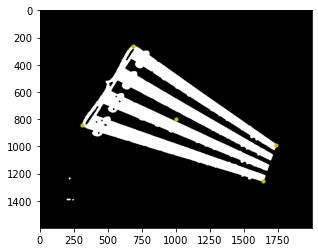

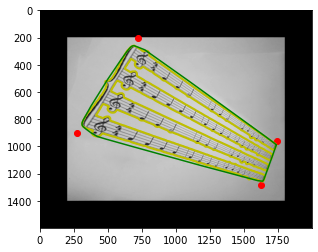

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


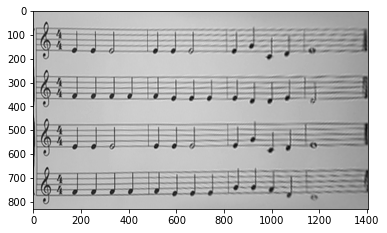

In [8]:
img = cv.imread("input/" + "so_tilted.png", 0)
img = resize(img)
img_b = binarize(img, "cv_adaptive"); 

img = fix_projection(img_b, img)

plt.show()
plt.imshow(img, cmap=plt.cm.gray)
io.imsave("output.png", img)